In [3]:
%run 00_analysis_config.ipynb

In [4]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

import lsfit
reload(lsfit)

import include_modules_root as rt
import Kalman_tom

In [5]:
# Figure save path prefix
savefig.fig_prefix = "plots/singletrack_"    # It's good to keep figures in a separate folder. Can also be set to None.
savefig.SAVE = False         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.

### Generate simulation script

The script is then submitted with the python file in scripts/submit_jobs_singletrack_large_angle.py

In [11]:
#-------------------
# 1. Gun at the center of the module
vertex = np.array([124.5, 5, 1])*1000 # mm
nevents = 160_000 # number of events
p_mag = 100_000 # MeV/c
rng = np.random.default_rng(seed=1)
theta_range=np.arctan(44.5/8)
data_filename = "scripts/muon_large_angle.txt"
with open(data_filename,"w+")  as f:
    f.write(f"# nevents {nevents}\n")
    for i in range(nevents):
        theta = rng.uniform(-theta_range, theta_range)
        phi = rng.uniform(0, 2*np.pi)
        p_unit=np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)])
        p_unit=p_unit/np.sqrt(np.sum(p_unit**2))
        p = p_mag*p_unit
        f.write(f"n {i}\n")
        f.write(f"\t 13 \t {vertex[0]} \t {vertex[1]} \t {vertex[2]}  \t {p[0]} \t {p[1]} \t {p[2]} \n")
        
        
with open(os.path.splitext(data_filename)[0]+".mac","w+")  as f:
    f.write(f"/det/select Box \n")
    f.write(f"/gen/select file_reader \n")
    f.write(f"/gen/file_reader/pathname {os.path.abspath(data_filename)} \n")
    f.write(f"/run/beamOn {nevents} \n")
    
    
#-------------------
# 2. momentum From CMS to any point in the decay volume
box_lim = np.array([[70.0, 70+99], [-49.5, 49.5], [-6, 25-6]])*1000 # xyz limit of the decay volume, detector coordinate
z_cms = 85.47*1000 # z offset of CMS
data_filename = "scripts/muon_cms.txt"

with open(data_filename,"w+")  as f:
    f.write(f"# nevents {nevents}\n")
    for i in range(nevents):
        vertex = np.array([rng.uniform(*box_lim[0]), rng.uniform(*box_lim[1]), rng.uniform(*box_lim[2])])
        p_unit = vertex-[0,0,z_cms]
        p_unit=p_unit/np.sqrt(np.sum(p_unit**2))
        p = p_mag*p_unit
        f.write(f"n {i}\n")
        f.write(f"\t 13 \t {vertex[0]} \t {vertex[1]} \t {vertex[2]}  \t {p[0]} \t {p[1]} \t {p[2]} \n")
        
        
with open(os.path.splitext(data_filename)[0]+".mac","w+")  as f:
    f.write(f"/det/select Box \n")
    f.write(f"/gen/select file_reader \n")
    f.write(f"/gen/file_reader/pathname {os.path.abspath(data_filename)} \n")
    f.write(f"/run/beamOn {nevents} \n")    

# Run with:
# simulation -q -o /project/def-mdiamond/tomren/mathusla/data/fit_study_6layer/muon_100_GeV_large_angle/ -s muon_large_angle.mac

### Check the angle range

In [6]:
filenames = [f"{DATA_DIR}/muon_100_GeV_large_angle//20230518/180557/run0.root",f"{DATA_DIR}/muon_100_GeV_CMS//20230518/180557/run0.root",]
filenames_recon = [f"{DATA_DIR}/muon_100_GeV_large_angle//20230518/180557/stat_seedmod.root",f"{DATA_DIR}/muon_100_GeV_CMS//20230518/180557/stat_seedmod.root",]

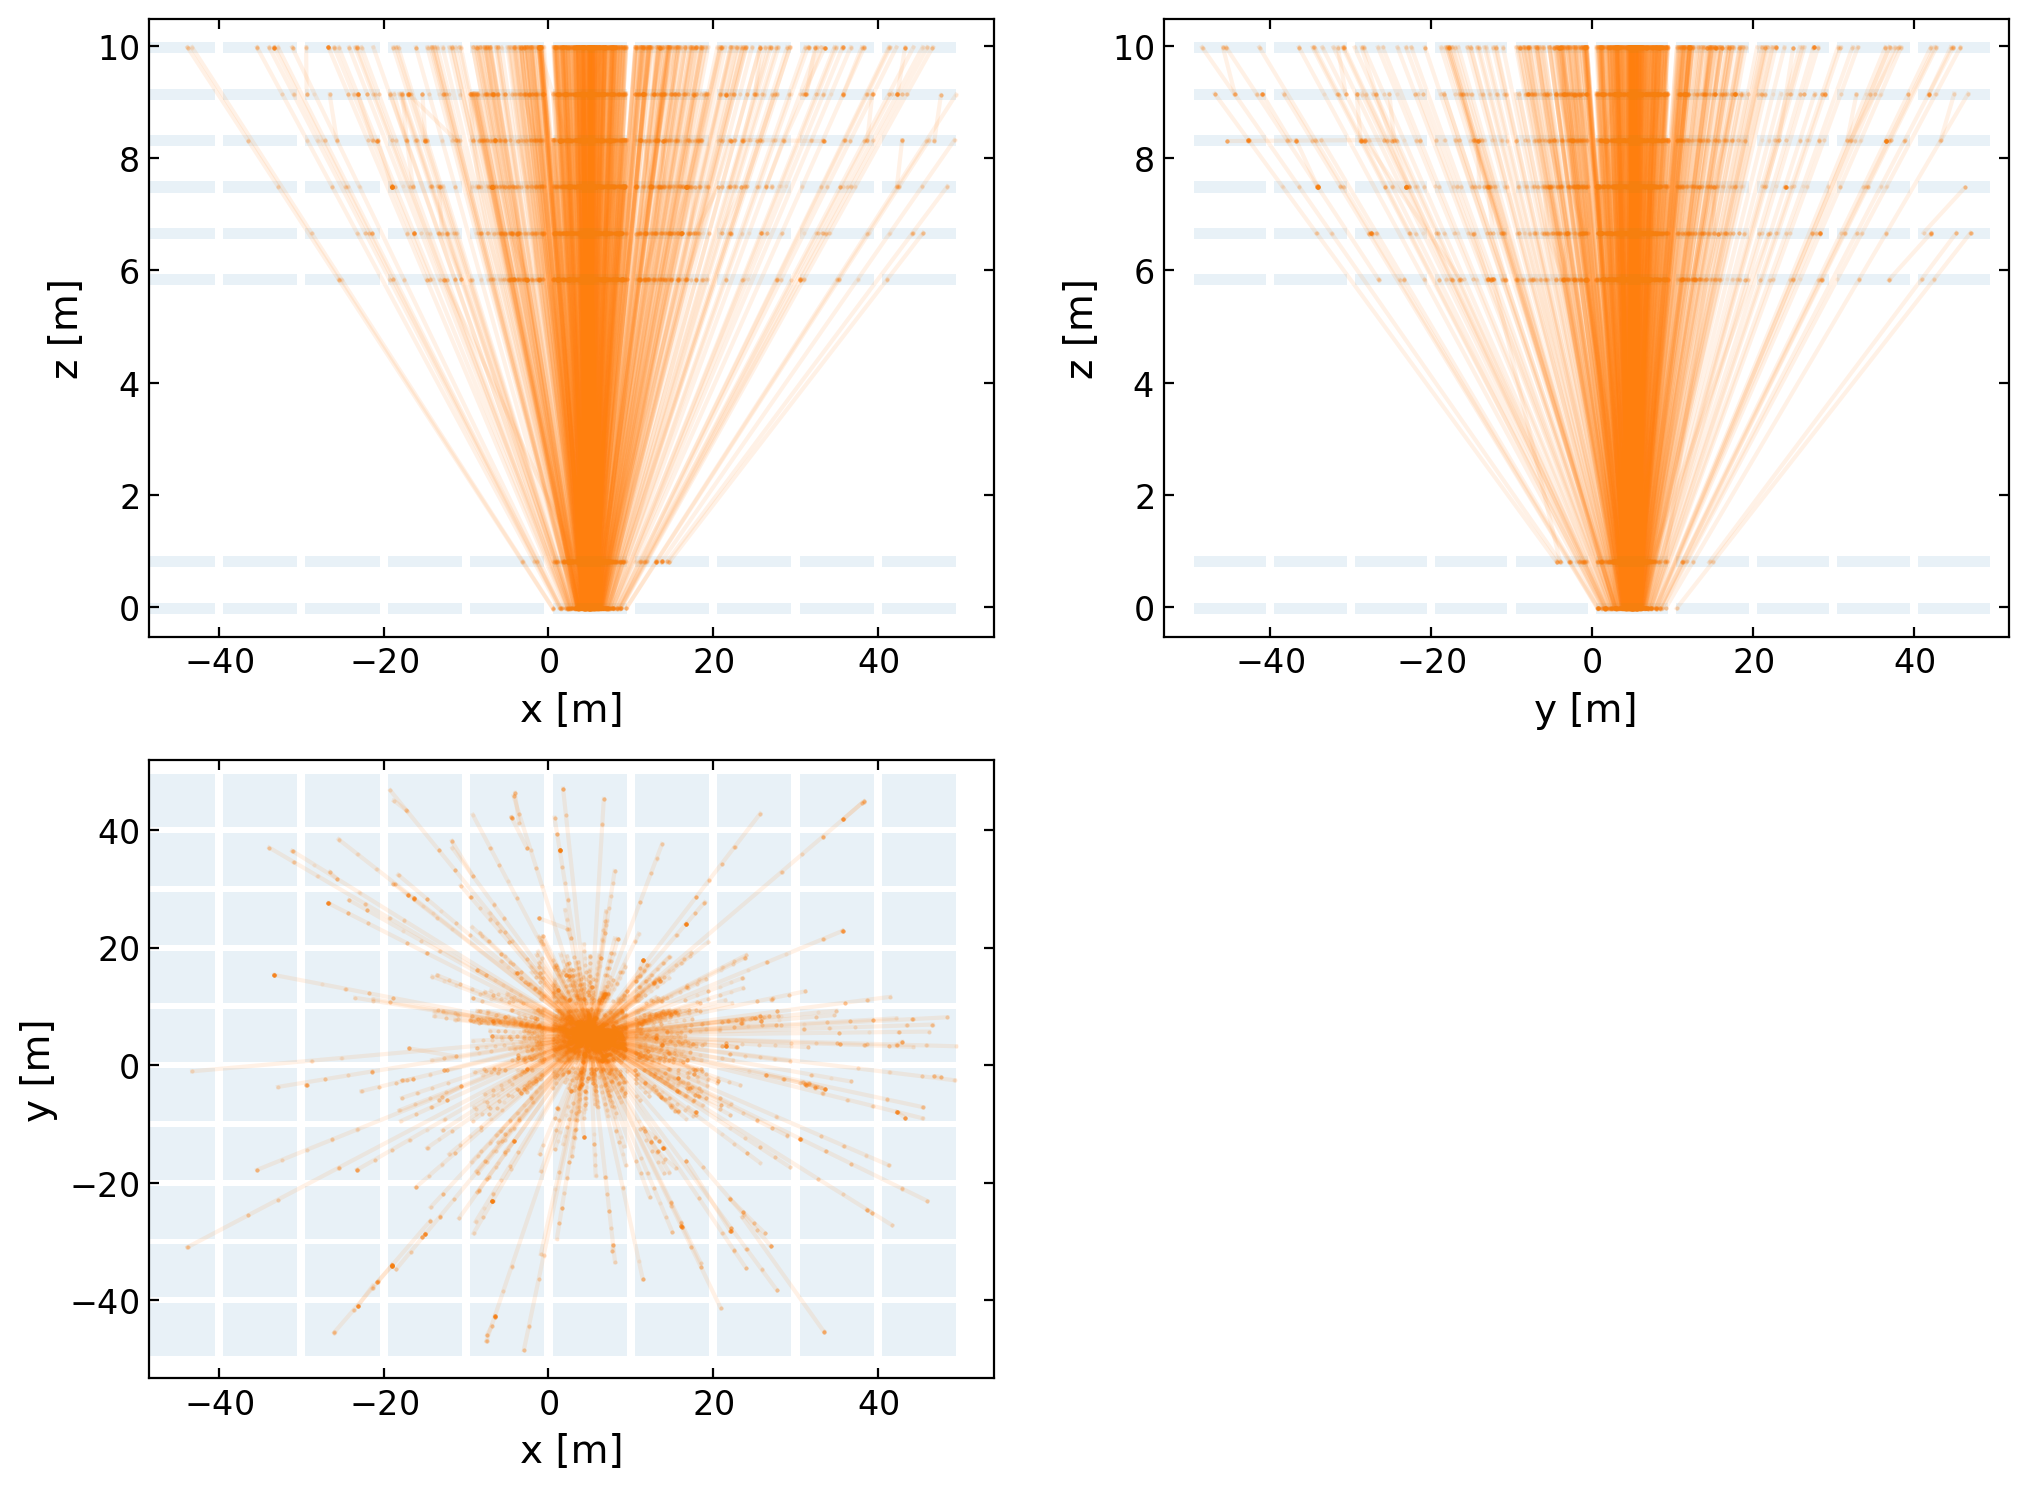

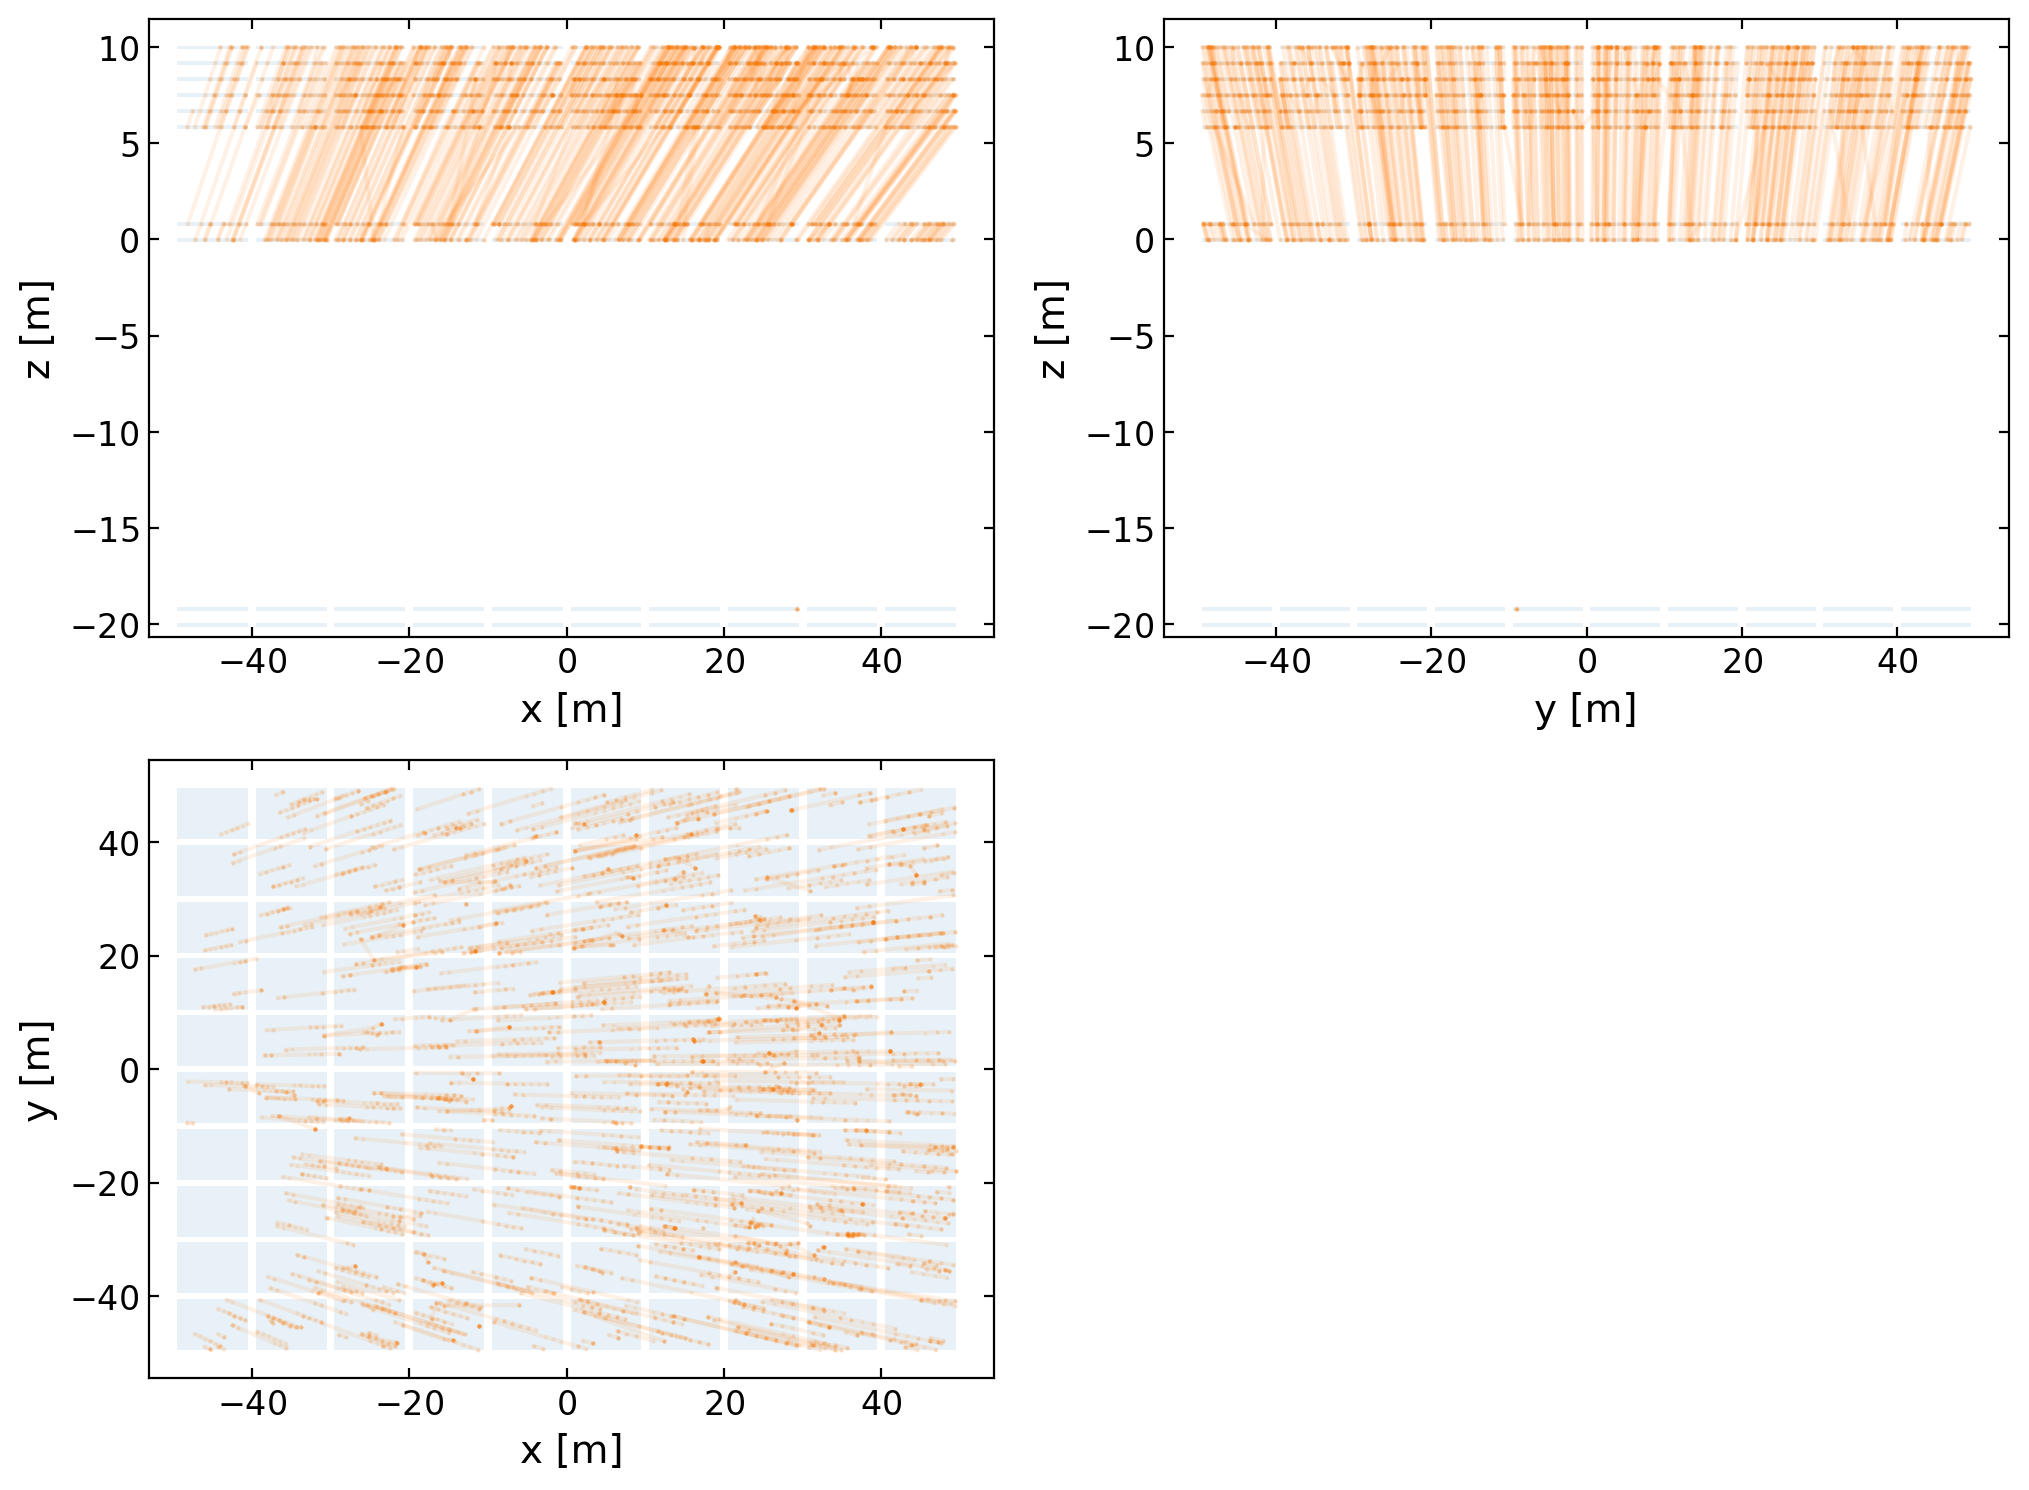

In [7]:
tree_name = "box_run"

vis.plot_multiple_events(filenames[0], tree_name, nevents=600)
vis.plot_multiple_events(filenames[1], tree_name, nevents=600)



# Efficiency vs angle

In [17]:
data = lsfit.get_km(filenames_recon[0])

100%|██████████| 160000/160000 [01:11<00:00, 2240.92it/s]


In [12]:
vertex_CMS = np.array([-vertex[1], -vertex[2]+85.47, vertex[0]])*100

In [18]:
data["theta"] = np.arccos(data["truth"][:,5]/np.sqrt(data["truth"][:,4]**2 + data["truth"][:,5]**2 + data["truth"][:,6]**2))
data["phi"] = np.arccos(data["truth"][:,6]/np.sqrt(data["truth"][:,4]**2 + data["truth"][:,6]**2))

Text(0.5, 0, '$\\theta$ [$^{\\circ}$]')

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


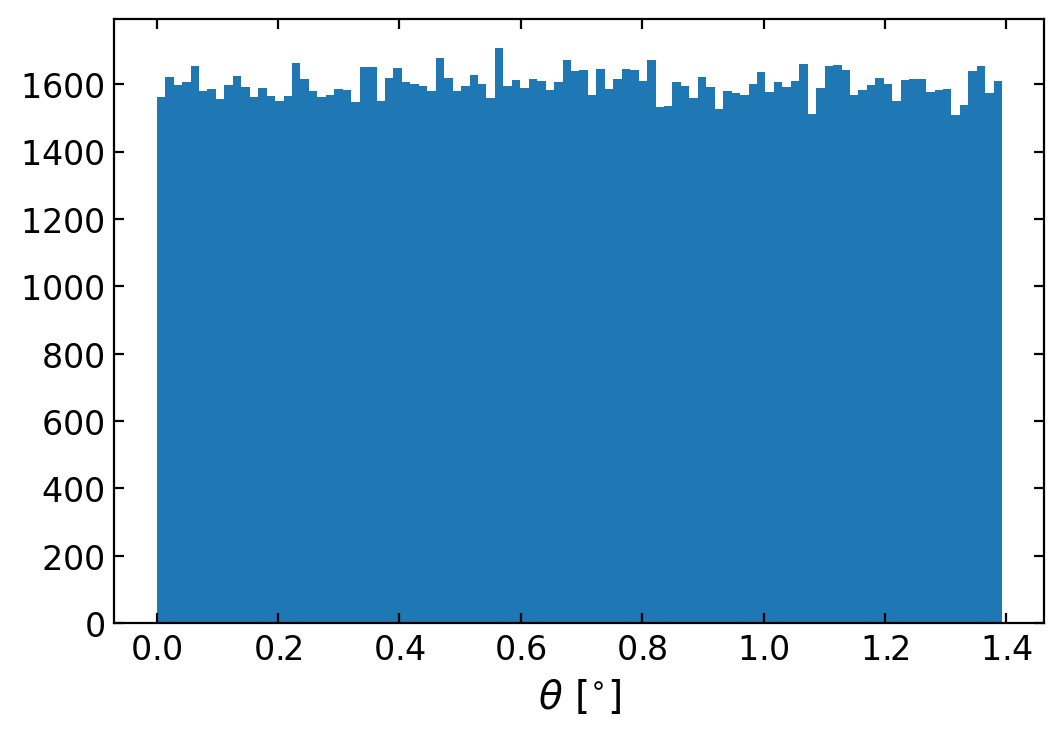

In [19]:
hist(data["theta"]);
xlabel(r"$\theta$ [$^{\circ}$]")

In [20]:
# Make a fixed range cut for tight and looser track
recon = data["recon"]
truth = data["truth"]
diffx = recon[:,2]-truth[:,2]
diffy = recon[:,0]-truth[:,0]
diffvx = recon[:,6]-truth[:,6]
diffvy = recon[:,4]-truth[:,4] 
mask_TIGHT  = (np.abs(diffx)<5) & (np.abs(diffy)<5) & (np.abs(diffvx)<0.5) & (np.abs(diffvy)<0.5)
mask_LOOSER = (np.abs(diffx)<10) & (np.abs(diffy)<10) & (np.abs(diffvx)<1) & (np.abs(diffvy)<1)

(0.0, 1.0)

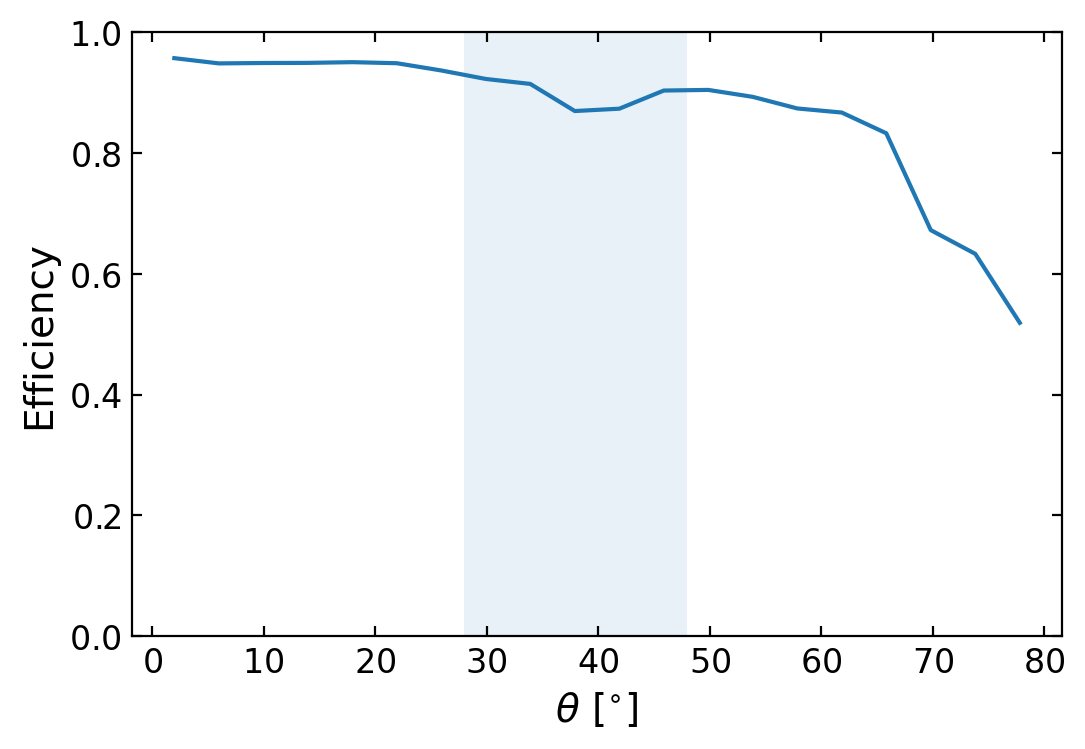

In [25]:
n_cuts = 20
bins = np.linspace(min(data["theta"]), max(data["theta"]), n_cuts+1)
bincenters = 0.5*(bins[1:]+bins[:-1])
eff = []
for i in range(n_cuts):
    mask = (data["theta"]>bins[i])&(data["theta"]<bins[i+1])
    n_pass = sum(data["mask_recon_success"]&mask_LOOSER&mask)
    n_total = sum(mask)
    eff.append(n_pass/n_total)
    
angle_firstgap = np.array([np.arctan(4.5*1.414/12),np.arctan(5.5*1.414/7)]    )
    
plot(bincenters/np.pi*180,eff)
axvspan(*angle_firstgap/np.pi*180, alpha=0.1,label="First gap")
xlabel(r"$\theta$ [$^{\circ}$]")
ylabel("Efficiency")
ylim(0,1)

# Efficiency of muons from CMS

In [12]:
data = lsfit.get_km(filenames_recon[1])

100%|██████████| 132731/132731 [00:50<00:00, 2632.96it/s]
/project/6035200/tomren/jupyter/tracker_6layers/lsfit.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_fit[key]=np.array(results_fit[key])


In [14]:
n_pass = sum(data["mask_recon_success"])
n_total = 160_000
efficiency = n_pass/n_total
print("CMS muon Efficiency", efficiency)

CMS muon Efficiency 0.57989375
